## RL algorithms

In [1]:
import gym

import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

#### RL algorithms

- We used the PPO algorithm for almost the entire course (except offline RL)
- In fact, RLlib offers many algorithms! See [here](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html).
- Let's look at one more algorithm, DQN.

Notes:

There are over 20 algorithms at the time of recording.

#### Deep Q-Network (DQN)

- DQN is famous in the RL world for many breakthroughs such as the [Atari results](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) from 2013.
- In RLlib, we only need to make the smallest of swaps:

PPO:

In [2]:
from ray.rllib.algorithms.ppo import PPOConfig

ppo = PPOConfig().framework("torch").build(env="FrozenLake-v1")

DQN:

In [3]:
from ray.rllib.algorithms.dqn import DQNConfig

dqn = DQNConfig().framework("torch").build(env="FrozenLake-v1")

2022-07-31 14:24:12,717	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.algorithms.dqn.dqn.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.dqn.dqn.DQNConfig(...)` instead. This will raise an error in the future!
2022-07-31 14:24:12,719	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!


And that's it!

#### PPO vs. DQN on Frozen Lake

In [19]:
t = time.time()
ppo_results = []
for i in range(30):
    ppo_results.append( ppo.train()["episode_reward_mean"] )
print(f"Elapsed time {time.time()-t:.1f} s")

Elapsed time 40.9 s


In [20]:
t = time.time()
dqn_results = []
for i in range(30):
    dqn_results.append( dqn.train()["episode_reward_mean"] )
print(f"Elapsed time {time.time()-t:.1f} s")

Elapsed time 35.0 s


#### PPO vs. DQN on Frozen Lake

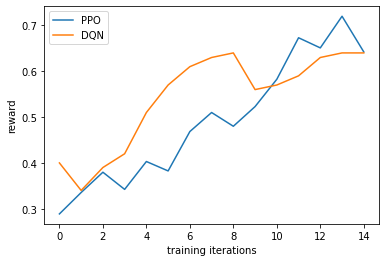

In [21]:
plt.plot(ppo_results, label="PPO")
plt.plot(dqn_results, label="DQN")
plt.legend();
plt.xlabel("training iterations");
plt.ylabel("reward");

- In this particular run of this case, the two algorithms seem to do about equally well.
- But, in general, one may be more suitable than the other.

Notes:

As in supervised learning, if you don't have domain expertise, an empirical approach is practical: try a few algorithms. PPO is a workhorse of RL, similar to something like a random forest or XGBoost in SL. That is why we focused on it in this course.

#### Under the hood

- Under the hood PPO and DQN work very differently
- PPO is an **on-policy** algorithm, DQN is **off-policy**
- They also have similarities, e.g. both are _model-free_ methods

Notes:

- PPO trains while running its own policy
- DQN can train on _experiences_ that may come from another policy (related to offline RL)
- DQN learns like offline RL (from data) but it is always generating new data from the env

#### Q-values

- One big difference is that DQN directly learns _Q-values_
- For each state-action pair, a Q-value is a measure of "goodness" of taking that action.
- There are also Q-values for each state, independent of actions. Let's start with these.

In [53]:
import utils

In [9]:
env = gym.make("FrozenLake-v1")

In [54]:
utils.get_q_state(dqn, env, 3) # See GitHub for the source code

0.16610734164714813

Apparently the observation "3" (player at top-right) has a "value" of 0.16.

With PPO, Q-values are not available:

In [55]:
utils.get_q_state(ppo, env, 3)

AttributeError: 'FullyConnectedNetwork' object has no attribute 'get_state_value'

#### Q-values

We can look at these for all 16 observations using a plot:

In [56]:
q_s = [utils.get_q_state(dqn, env, i) for i in range(16)]
print(q_s)

[0.4116215705871582, 0.19895410537719727, 0.2634722888469696, 0.16610734164714813, 0.3124083876609802, 0.1859903633594513, 0.21589764952659607, 0.3183194696903229, 0.30947205424308777, 0.4118478000164032, 0.4248697757720947, 0.22886475920677185, 0.25970426201820374, 0.5032680034637451, 0.7400635480880737, 0.31121334433555603]


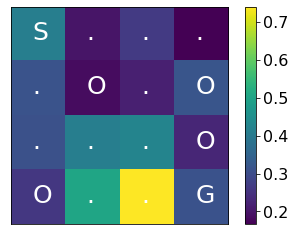

In [59]:
utils.q_state_plot_frozenlake(q_s, env) # See GitHub for the source code

Notes:
    
Here we see that the most desirable state is the one before the goal. We can also see that the states have higher Q values as they get nearer the goal. Remember that this is the slippery Frozen Lake, so winning isn't guaranteed and being closer to the goal is indeed better.

The Q-values for the end states (O and G) don't look particularly meaningful. 

#### Q-values

Let's now look at the state-action Q-values.

In [60]:
utils.get_q_state_action(dqn, env, 3) # # See GitHub for the source code

array([ 0.0029173 ,  0.00149198, -0.00736461,  0.11139473], dtype=float32)

This is consistent with a coding exercise from earlier, where we saw the agent tries to move up in this situation (using PPO in that case).

In [61]:
q_sa = np.array([get_q_state_action(dqn, env, i) for i in range(16)])
q_sa

array([[ 0.0088903 , -0.01286292, -0.03412018, -0.00382777],
       [-0.05129048, -0.00838892, -0.13734458,  0.0988894 ],
       [ 0.02749778,  0.01311466, -0.02323138,  0.01477144],
       [ 0.0029173 ,  0.00149198, -0.00736461,  0.11139473],
       [ 0.14435405, -0.00871129, -0.06975938,  0.01305549],
       [ 0.0034796 , -0.05827228,  0.10638069, -0.03048788],
       [ 0.0594745 , -0.00388548,  0.0203508 , -0.08703135],
       [-0.07572865, -0.01463264,  0.02287911,  0.00697899],
       [-0.12751591, -0.06583301, -0.10803185,  0.09258421],
       [-0.0664983 ,  0.12165849, -0.10849473, -0.13943659],
       [ 0.1733895 , -0.00418257, -0.01920396, -0.22108737],
       [-0.07049423, -0.03574087,  0.11100063,  0.07036274],
       [-0.04510463, -0.08504594, -0.08470869, -0.15281594],
       [-0.10746758, -0.09605262,  0.08242726, -0.19105414],
       [-0.050584  ,  0.03680855, -0.04779096, -0.07337979],
       [-0.06486548,  0.04281203,  0.03018547, -0.06062168]],
      dtype=float32)

#### Q-values

We can plot these 64 (16x4) Q-values:

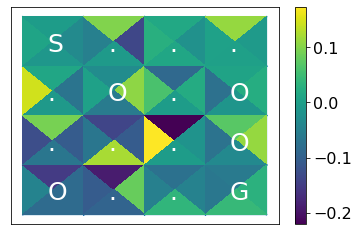

In [110]:
utils.q_state_action_plot_frozenlake(q_sa, env) # See GitHub for source code

Interesting observations:

- We again see the desire to move up from the top-right.
- The strongest desire is to not die at square 10. Moving left is the only 100% safe move.
- Why move down at square 14? Because 13 is better than 10.
  - You can confirm that by scrolling back to the state Q-value plot!

Notes:
    
I could stare at this plot all day!

In [109]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/Users/mike/git/anyscale/rl-course/notebooks/05-under-the-hood/utils.py'>

#### Beyond DQN

#### Let's apply what we learned!

## MCQ
<!-- multiple choice -->

on off policy

- [ ] lr
- [ ] train_batch_size
- [ ] num_sgd_iter
- [x] entropy_coeff